In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path="/content/drive/MyDrive/Research/Hard_Attention/dataset_2/m_5_size_100/run_"

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/hard_attention')

# Generate dataset

In [5]:
np.random.seed(1)

y = np.concatenate((np.zeros(500),np.ones(500),np.ones(500)*2,np.ones(500)*3,np.ones(500)*4,
                    np.ones(500)*5,np.ones(500)*6,np.ones(500)*7,np.ones(500)*8,np.ones(500)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [6]:
x = np.zeros((5000,2))

In [7]:
np.random.seed(12)

x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))

In [8]:
x[idx[0]][0], x[idx[2]][5] 

(array([4.04729858, 6.43185741]), array([4.53008447, 4.5079931 ]))

In [9]:
print(x.shape,y.shape)

(5000, 2) (5000,)


In [10]:
idx= []
for i in range(10):
  idx.append(y==i)

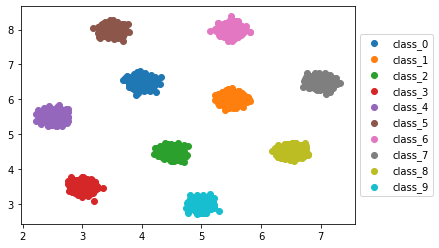

In [11]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
x = ( x -  np.mean(x,axis=0,keepdims=True) ) / np.std(x,axis=0,keepdims=True) 


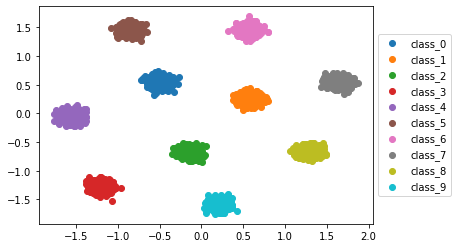

In [13]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [15]:
desired_num = 1100
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 2000
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████| 1100/1100 [02:06<00:00,  8.69it/s]


In [16]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [17]:
len(mosaic_list_of_images), mosaic_list_of_images[0],mosaic_list_of_images[0].shape

(1100, array([[ 1.41860713, -0.6338838 ],
        [ 0.60177752,  1.40622261],
        [ 0.64672986,  1.41882828],
        ...,
        [ 0.1760838 , -1.64428378],
        [ 0.57482959,  1.52453398],
        [ 1.71875213,  0.627341  ]]), (2000, 2))

In [18]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [19]:
batch = 50
msd1 = MosaicDataset(mosaic_list_of_images[0:100], mosaic_label[0:100] , fore_idx[0:100])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [20]:
data,_,_=iter(train_loader).next()

In [21]:
data.shape

torch.Size([50, 2000, 2])

In [22]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[100:], mosaic_label[100:] , fore_idx[100:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [23]:
class Focus(nn.Module):
    def __init__(self):
        super(Focus, self).__init__()
        self.fc1 = nn.Linear(2,50, bias=False)
        self.fc2 = nn.Linear(50,1,bias=False)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        #self.fc2 = nn.Linear(64, 1, bias=False)
        #torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self,z):
        #print("data",z)
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)

        alpha = F.softmax(alp1,dim=1)
        #print(self.training)
        
        if self.training:
            alpha =alpha[:,:,0]
            y = ft1 
            return alpha,y
        else:
            #alpha_cumsum = torch.cumsum(alpha, dim = 1)
            #print(alpha_cumsum)
            #len_batch = alpha_cumsum.size(0)
            #patches = alpha_cumsum.size(1)
            #rand_prob = torch.rand(len_batch,patches, 1).to(device)
            #alpha_relu = F.relu(rand_prob-alpha_cumsum)
            #print(alpha_relu)
            #alpha_index = torch.count_nonzero(alpha_relu,dim=1)
            #alpha_hard = F.one_hot(alpha_index,num_classes=patches)
            #print(alpha_hard)
            #alpha_hard = torch.transpose(alpha_hard,dim0=1,dim1=2)
            #print(ft1,"alpha_hard",alpha_hard) 
            #y = torch.sum(alpha_hard*ft1,dim=1)
            #print(alpha,alpha.shape)
         
        
            index = torch.argmax(alpha,dim=1)
            hard_alpha = torch.nn.functional.one_hot(index[:,0], patches)
            y = torch.sum(hard_alpha[:,:,None]*ft1,dim=1)
            alpha = alpha[:,:,0]
            return alpha,y
    
    def helper(self, x):
        x1 = x
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x,x1

In [24]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)

  def forward(self, x):
    #print(x.shape)
    #x = x.view(-1, 1)
    #print(x.shape)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [54]:
torch.manual_seed(13)
focus_net = Focus().double()
focus_net = focus_net.to(device)

In [55]:
torch.manual_seed(13)
classify = Classification().double()
classify = classify.to(device)

In [56]:
import torch.optim as optim
optimizer_classify = optim.Adam(classify.parameters(), lr=0.1 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.1 ) #, momentum=0.9)

In [57]:
def my_cross_entropy(output,target,alpha):
    criterion = nn.CrossEntropyLoss(reduce=False)
    
    batch = output.size(0)
    #print(batch)
    patches = output.size(1)
    classes = output.size(2)
    
    
    
    output = torch.reshape(output,(batch*patches,classes))
    
    
    target = target.repeat_interleave(patches)
    
    loss = criterion(output,target)
    
    #print(loss,loss.shape)
    loss = torch.reshape(loss,(batch,patches))
    #print(loss.size())
    final_loss = torch.sum(torch.mul(loss,alpha),dim=1)
    #print(final_loss.shape)
    final_loss = torch.mean(final_loss,dim=0)
    
    
    
    #print(final_loss)
    return final_loss
    
    
    

In [58]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [59]:
def plot_attended_data(trainloader,net,epoch):
    attd_data =[]
    lbls = []
    for data in trainloader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
        alphas, avg_images = focus_net(inputs)
        attd_data.append(avg_images.numpy())
        lbls.append(labels)
    attd_data = np.concatenate(attd_data,axis=0)
    lbls = np.concatenate(lbls,axis=0)
    plt.figure(figsize=(6,8))
    plt.scatter(attd_data[:,0],attd_data[:,1],c=lbls)
    plt.title("EPOCH_"+str(epoch))

In [60]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    loss = my_cross_entropy(outputs,labels,alphas)
    print(loss)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)


print("="*100)



tensor(1.1721, device='cuda:0', dtype=torch.float64)
tensor(1.1741, device='cuda:0', dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [61]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)


In [62]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[-0.1181, -0.0030],
        [-0.4268,  0.2945],
        [ 0.2314, -0.0850],
        [ 0.2047,  0.3473],
        [ 0.1353, -0.0880],
        [ 0.0341, -0.1290],
        [ 0.0430, -0.1165],
        [ 0.0171, -0.0899],
        [ 0.2401, -0.0346],
        [-0.2021,  0.1027],
        [-0.4337, -0.2103],
        [ 0.1129, -0.1162],
        [ 0.1906, -0.4065],
        [-0.1823, -0.6261],
        [-0.3808, -0.0406],
        [ 0.4075, -0.2476],
        [-0.0116, -0.2889],
        [ 0.5438, -0.4551],
        [ 0.2557,  0.1164],
        [-0.1854,  0.4136],
        [-0.1875,  0.0379],
        [-0.1165, -0.1601],
        [-0.0614,  0.1823],
        [ 0.0824, -0.0428],
        [ 0.1910,  0.2516],
        [-0.1856,  0.1568],
        [-0.1999, -0.2636],
        [-0.0564,  0.2618],
        [-0.4972, -0.1039],
        [ 0.0093,  0.0324],
        [ 0.1483, -0.0172],
        [ 0.0681, -0.1813],
        [ 0.1324,  0.2163],
        [ 0.0371, -0.1833],
        [-0

In [63]:
nos_epochs = 2000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    batch = inputs.size(0)
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = my_cross_entropy(outputs, labels,alphas) 
    
    loss.backward()
    
    
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 2
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1

  if(np.mean(epoch_loss) <= 0.01):
      break;
  #plot_attended_data(train_loader,focus_net,epoch)

    
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[1,     2] loss: 1.146
[2,     2] loss: 1.100
[3,     2] loss: 1.101
[4,     2] loss: 1.087
[5,     2] loss: 1.087
[6,     2] loss: 1.086
[7,     2] loss: 1.090
[8,     2] loss: 1.086
[9,     2] loss: 1.086
[10,     2] loss: 1.092
[11,     2] loss: 1.086
[12,     2] loss: 1.086
[13,     2] loss: 1.090
[14,     2] loss: 1.088
[15,     2] loss: 1.087
[16,     2] loss: 1.092
[17,     2] loss: 1.093
[18,     2] loss: 1.094
[19,     2] loss: 1.088
[20,     2] loss: 1.086
[21,     2] loss: 1.089
[22,     2] loss: 1.104
[23,     2] loss: 1.090
[24,     2] loss: 1.087
[25,     2] loss: 1.091
[26,     2] loss: 1.090
[27,     2] loss: 1.085
[28,     2] loss: 1.086
[29,     2] loss: 1.089
[30,     2] loss: 1.094
[31,     2] loss: 1.086
[32,     2] loss: 1.086
[33,     2] loss: 1.085
[34,     2] loss: 1.093
[35,     2] loss: 1.086
[36,     2] loss: 1.093
[37,     2] loss: 1.091
[38,     2] loss: 1.085
[39,     2] loss: 1.087
[40,     2] loss: 1.086
[41,     2] loss: 1.086
[42,     2] loss: 1.087
[

In [64]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[-8.8892e-01, -3.8771e-01],
        [-1.1981e+00, -2.3822e-01],
        [ 1.0971e+01,  1.1323e+00],
        [-4.5799e-01, -2.0478e-01],
        [ 8.6294e+00,  2.1909e-01],
        [-6.3992e-01, -5.4036e-01],
        [ 1.3626e+01,  1.5266e+00],
        [ 1.0843e+01,  1.0723e+00],
        [ 1.2877e+01,  9.5447e-01],
        [-9.1943e-01, -4.3421e-01],
        [ 1.5231e-02, -6.3514e-01],
        [ 7.1811e+00,  7.6625e-01],
        [ 4.1888e+00,  8.7621e-01],
        [ 5.7911e-01, -2.6002e+00],
        [-3.1988e-01,  5.0750e-01],
        [ 5.9173e+00, -1.8800e-01],
        [-8.0049e-01, -7.0405e-01],
        [ 2.4641e+00,  4.3749e-01],
        [-5.1758e-01, -3.4092e-01],
        [-7.8968e-01, -2.7476e-01],
        [ 8.2157e-01,  5.7399e-01],
        [-7.9973e-01, -8.3953e-01],
        [ 9.0895e+00,  1.0708e+00],
        [ 1.3052e+01,  1.0188e+00],
        [ 8.4236e+00,  9.4509e-01],
        [-1.1066e+00, -1.0376e-01],
        [-8.8645e-01, -9.48

In [65]:
correct = 0
total = 0

focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    #print(outputs.shape)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the train images: 40.000000 %
total correct 40
total train set images 100


In [66]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the test images: 31.200000 %
total correct 312
total train set images 1000
